In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from datasets import load_dataset

In [2]:
RAW_DIR = Path("C:/IP/greenmlops/data/raw/ag_news")
OUT_DIR = Path("C:/IP/greenmlops/data/processed/ag_news")
RAW_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
dataset = load_dataset("ag_news", cache_dir=str(RAW_DIR))

train_data = dataset["train"].to_pandas()
test_data  = dataset["test"].to_pandas()

print(f"Train samples : {len(train_data)}")
print(f"Test samples  : {len(test_data)}")
print(f"Columns       : {train_data.columns.tolist()}")
print(f"Label values  : {sorted(train_data['label'].unique())}")

Train samples : 120000
Test samples  : 7600
Columns       : ['text', 'label']
Label values  : [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


In [4]:
label_names = dataset["train"].features["label"].names
print(f"Label names: {label_names}")

label_counts = train_data["label"].value_counts().sort_index()
for idx, count in label_counts.items():
    print(f"  {idx} - {label_names[idx]}: {count}")

Label names: ['World', 'Sports', 'Business', 'Sci/Tech']
  0 - World: 30000
  1 - Sports: 30000
  2 - Business: 30000
  3 - Sci/Tech: 30000


In [5]:
for label_idx, name in enumerate(label_names):
    sample = train_data[train_data["label"] == label_idx]["text"].iloc[0]
    print(f"\n[{name}]\n{sample}")


[World]
Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.

[Sports]
Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminaries.

[Business]
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

[Sci/Tech]
'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high\on Tuesday among the guys at 

In [6]:
train_data["text_len"] = train_data["text"].str.len()

print("=== TEXT LENGTH STATS (characters) ===")
print(train_data["text_len"].describe().round(1))
print(f"\nTexts under 100 chars  : {(train_data['text_len'] < 100).sum()}")
print(f"Texts over 1000 chars  : {(train_data['text_len'] > 1000).sum()}")

=== TEXT LENGTH STATS (characters) ===
count    120000.0
mean        236.5
std          66.5
min         100.0
25%         196.0
50%         232.0
75%         266.0
max        1012.0
Name: text_len, dtype: float64

Texts under 100 chars  : 0
Texts over 1000 chars  : 6


In [7]:
train_data["word_count"] = train_data["text"].str.split().str.len()

print("=== WORD COUNT STATS ===")
print(train_data["word_count"].describe().round(1))

=== WORD COUNT STATS ===
count    120000.0
mean         37.8
std          10.1
min           8.0
25%          32.0
50%          37.0
75%          43.0
max         177.0
Name: word_count, dtype: float64


### plots

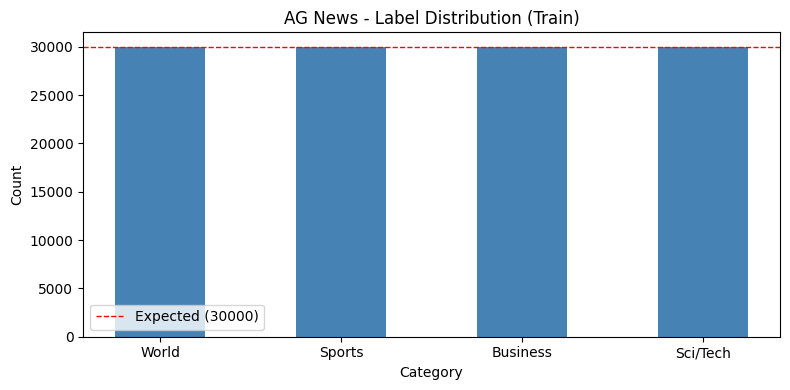

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(
    [label_names[i] for i in label_counts.index],
    label_counts.values,
    color="steelblue",
    width=0.5
)
ax.set_title("AG News - Label Distribution (Train)")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
ax.axhline(y=30000, color="red", linestyle="--", linewidth=1, label="Expected (30000)")
ax.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "label_distribution.png", dpi=150)
plt.show()

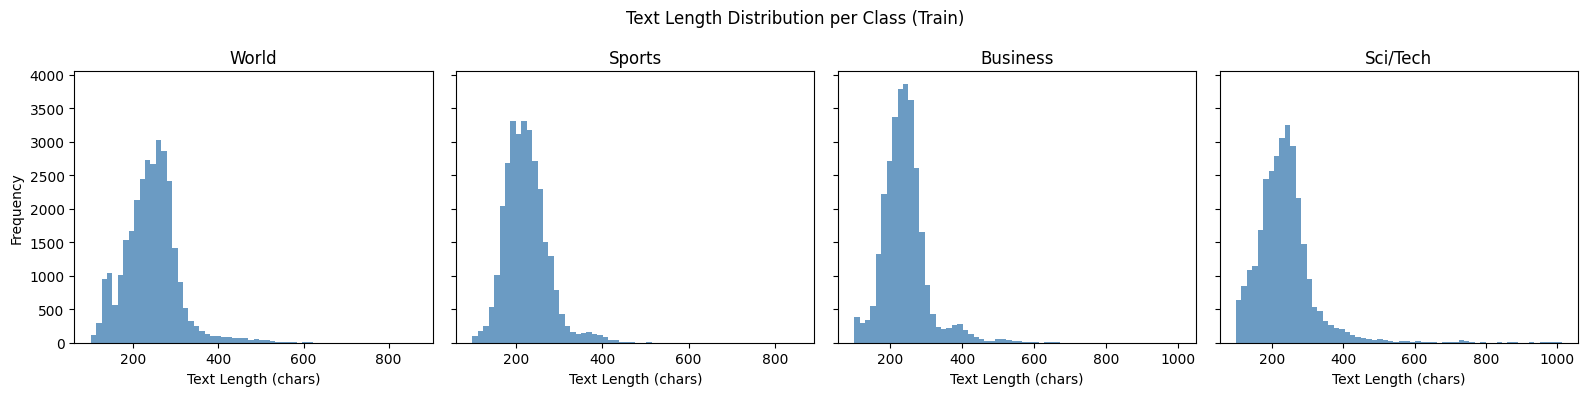

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for i, name in enumerate(label_names):
    subset = train_data[train_data["label"] == i]["text_len"]
    axes[i].hist(subset, bins=60, color="steelblue", alpha=0.8)
    axes[i].set_title(name)
    axes[i].set_xlabel("Text Length (chars)")
    if i == 0:
        axes[i].set_ylabel("Frequency")

plt.suptitle("Text Length Distribution per Class (Train)")
plt.tight_layout()
plt.savefig(OUT_DIR / "text_length_distribution.png", dpi=150)
plt.show()

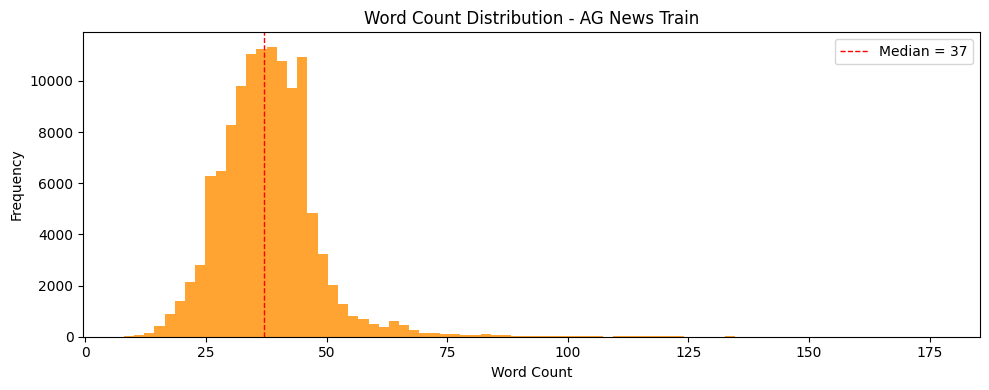

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(train_data["word_count"], bins=80, color="darkorange", alpha=0.8)
ax.set_title("Word Count Distribution - AG News Train")
ax.set_xlabel("Word Count")
ax.set_ylabel("Frequency")
ax.axvline(
    x=train_data["word_count"].median(),
    color="red", linestyle="--", linewidth=1,
    label=f"Median = {train_data['word_count'].median():.0f}"
)
ax.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "word_count_distribution.png", dpi=150)
plt.show()

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased",
    local_files_only=False
)

sample_texts = train_data["text"].sample(2000, random_state=42).tolist()

token_lengths = []
for t in sample_texts:
    ids = tokenizer.encode(t, add_special_tokens=True, truncation=False)
    token_lengths.append(len(ids))

print("=== TOKEN LENGTH STATS (2000 sample) ===")
print(f"  Min    : {min(token_lengths)}")
print(f"  Max    : {max(token_lengths)}")
print(f"  Mean   : {np.mean(token_lengths):.1f}")
print(f"  Median : {np.median(token_lengths):.0f}")
print(f"  >512 tokens (truncated by DistilBERT): {sum(t > 512 for t in token_lengths)}")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

c:\Users\arunp\anaconda3\envs\mlops\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


=== TOKEN LENGTH STATS (2000 sample) ===
  Min    : 21
  Max    : 348
  Mean   : 53.2
  Median : 50
  >512 tokens (truncated by DistilBERT): 0


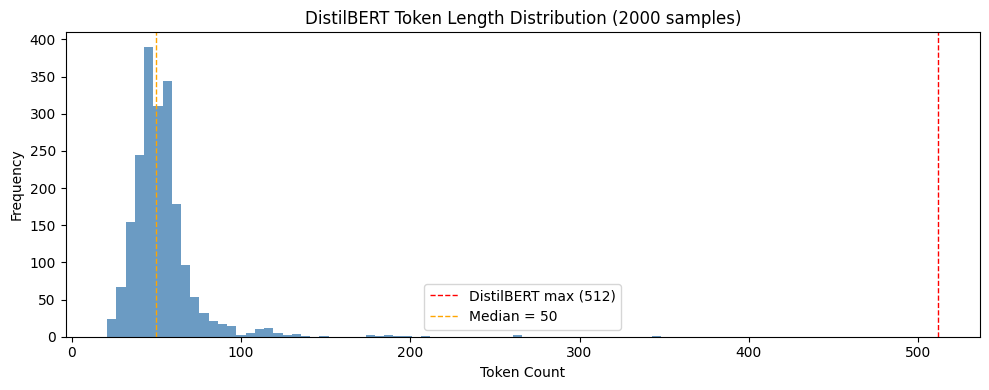

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(token_lengths, bins=60, color="steelblue", alpha=0.8)
ax.axvline(x=512, color="red", linestyle="--", linewidth=1, label="DistilBERT max (512)")
ax.axvline(
    x=np.median(token_lengths),
    color="orange", linestyle="--", linewidth=1,
    label=f"Median = {np.median(token_lengths):.0f}"
)
ax.set_title("DistilBERT Token Length Distribution (2000 samples)")
ax.set_xlabel("Token Count")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "token_length_distribution.png", dpi=150)
plt.show()

In [14]:
print(f"Null values in train : {train_data.isnull().sum().sum()}")
print(f"Null values in test  : {test_data.isnull().sum().sum()}")

dupes = train_data["text"].duplicated().sum()
print(f"Duplicate texts in train: {dupes}")

Null values in train : 0
Null values in test  : 0
Duplicate texts in train: 0


In [15]:
print("=== AG NEWS EDA SUMMARY ===")
print(f"Train samples    : {len(train_data)}")
print(f"Test samples     : {len(test_data)}")
print(f"Classes          : {label_names}")
print(f"Balanced         : {label_counts.min() == label_counts.max()}")
print(f"Avg text length  : {train_data['text_len'].mean():.0f} chars")
print(f"Avg word count   : {train_data['word_count'].mean():.0f} words")
print(f"Avg token length : {np.mean(token_lengths):.0f} tokens")
print(f"Texts >512 tokens: {sum(t > 512 for t in token_lengths)} / 2000 sampled")
print(f"\nSaved plots to   : {OUT_DIR}")

=== AG NEWS EDA SUMMARY ===
Train samples    : 120000
Test samples     : 7600
Classes          : ['World', 'Sports', 'Business', 'Sci/Tech']
Balanced         : True
Avg text length  : 236 chars
Avg word count   : 38 words
Avg token length : 53 tokens
Texts >512 tokens: 0 / 2000 sampled

Saved plots to   : C:\IP\greenmlops\data\processed\ag_news
